# Maximum likelihood estimator for proportion estimation of different hominin species - denomstration

## Imports and loading data:

In [22]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
import seaborn as sns
from ExplainableMaximumLikelihoodCalculator import ExplainableMaximumLikelihoodCalculator
import pysam
from Bio import SeqIO, Seq, SeqRecord, pairwise2
from Bio.pairwise2 import format_alignment
from LoadDataUtils import getListOfReadsFromBamFile, getListOfReadsFromFastaFile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import math
import shap
from scipy.stats import chisquare
from scipy.special import rel_entr
fileNameSapiens =  "data/simulatedData/human_chinese_AF346973_500samples.fas" #File that contains 500 reads from homo sapiens
fileNameNeanderthals =  "data/simulatedData/Neanderthal_Goyet_KX198085_500samples.fas" #File that contains 500 reads from neanderthal
fileNameDenisovans =  "data/simulatedData/denisova_kx663333_500samples.fas" #File that contains 500 reads from denisovan
neanderthals_500_generated = getListOfReadsFromFastaFile(fileNameNeanderthals)
sapiens_500_generated = getListOfReadsFromFastaFile(fileNameSapiens)
denisovan_500_samples = getListOfReadsFromFastaFile(fileNameDenisovans)
path_to_frequencies_table = "data/substitution_matrix.tsv"

## As a first example, we will analyze a dataset of 50 reads from each species

In [23]:
number_of_sapienses = 50
number_of_neanderthals = 50
number_of_denisovans = 50

total_length = number_of_sapienses + number_of_neanderthals + number_of_denisovans
all_indexes = [i for i in range(total_length)]
neanderthal_indexes = [i for i in all_indexes if i<number_of_neanderthals]
sapienses_indexes = [i for i in all_indexes if i>= number_of_neanderthals and i < number_of_sapienses + number_of_neanderthals]
denisovans_indexes = [i for i in all_indexes if i>= number_of_sapienses + number_of_neanderthals]

dataset_1 = neanderthals_500_generated[:number_of_neanderthals] + sapiens_500_generated[:number_of_sapienses] + denisovan_500_samples[:number_of_denisovans]

### Load references file names for all species

In [24]:
sapiens_reference_file_names = [
                    "data/reference_files/human_AF346981_French.fa",
                     "data/reference_files/human_AY195760_Korea.fa",
                      "data/reference_files/human_AY882416_Ethiopia.fa",
                      "data/reference_files/human_AY963586_Italian.fa",
                      "data/reference_files/human_AY195781_Caucasian.fa",
                      "data/reference_files/human_AY195757_Iraqi-Israeli.fa",
                      "data/reference_files/human_AY195749_NativeAmerican.fa"]
neanderthals_reference_file_names = [
                            "data/reference_files/neanderthal_mezmaiskaya1_FM865411.fa",
                           "data/reference_files/Neanderthal_Altai_KC879692.fa",
                           "data/reference_files/Neanderthal_Denisova11_full_mtDNA_KU131206.fa",
                           "data/reference_files/Neanderthal_Spy_94a_MG025538.fa",
                            "data/reference_files/Neanderthal_Vindija33.16_AM948965.fa",
                            "data/reference_files/Neanderthal_Vindija33.19_KJ533545.fa"]
denisovan_reference_file_names = [  
                        "data/reference_files/Denisova_MT576653.1.fa",
                        "data/reference_files/Denisova_MT576652.1.fa",
                        "data/reference_files/Denisova_4_FR695060.fa",
                        "data/reference_files/Denisova_8_KT780370.fa",
                        "data/reference_files/Denisova_manual_phalanx_NC_013993.fa",
                        "data/reference_files/Denisova_MT576651.1.fa"]

### Creating a maximum likelihood estimator - to estimate the contribution of each species to the data set:

In [11]:
maximum_likelihood_calculator_d_1 = ExplainableMaximumLikelihoodCalculator(dataset_1,
                                                ref_neanderthal_file_names=neanderthals_reference_file_names,
                                                ref_sapien_file_names=sapiens_reference_file_names,
                                                ref_denisovan_file_names=denisovan_reference_file_names,
                                                path_to_substitution_matrix=path_to_frequencies_table,
                                                number_of_jobs=-1)

Loading sequences and calculating alignments to all references, this might take a while. Number of reads:  150
start working on read number 0
start working on read number 10
start working on read number 20
start working on read number 30
start working on read number 40
start working on read number 50
start working on read number 60
start working on read number 70
start working on read number 80
start working on read number 90
start working on read number 100
start working on read number 110
start working on read number 120
start working on read number 130
start working on read number 140


### Estimation to the contribution of each species to the data set:
#### This compares the ground truth to the output of the system.

In [15]:
total_number_of_reads = maximum_likelihood_calculator_d_1.number_of_reads
estimation = maximum_likelihood_calculator_d_1.estimate_species_proportions(100)
actual_values = {'Homo Sapiens' : number_of_sapienses / total_number_of_reads, 'Neanderthals' : number_of_neanderthals / total_number_of_reads, 'Denisovans':number_of_denisovans / total_number_of_reads}
comparison = estimation.append(actual_values, ignore_index=True).rename(index={0: "Estimation", 1: "Actual"})
comparison


,Homo Sapiens,Neanderthals,Denisovans
Estimation,0.340000,0.330000,0.330000
Actual,0.333333,0.333333,0.333333


As you can see above, the system correctly estimated that the proportions are ($1 \over 3$, $1 \over 3$, $1 \over 3$).


### We will now analyze the accuracy of the model, as a function of the number of reads in a sample

[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140]
sample size: 10
sample size: 20
sample size: 30
sample size: 40
sample size: 50
sample size: 60
sample size: 70
sample size: 80
sample size: 90
sample size: 100
sample size: 110
sample size: 120
sample size: 130
sample size: 140


<AxesSubplot:xlabel='Number Of Reads', ylabel='KL_divergence_from_ground_truth'>

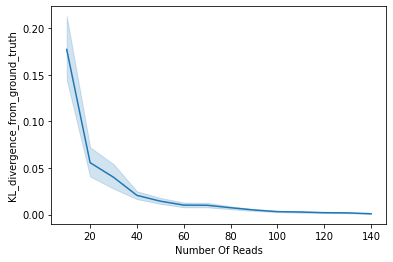

In [18]:
sample_sizes = [10*i for i in range(100) if i > 0 and 10*i < total_length]
print(sample_sizes)
indexes = [i for i in range(total_length)]
number_of_trials_per_sample_size = 100

data_kl = []
data_kl_guess = []

for sample_size in sample_sizes:
    print("Sampling datasets of sample size:", sample_size)
    chi_square_p_values_current = []
    number_of_samples = 0
    while (number_of_samples < number_of_trials_per_sample_size):
        sample = random.sample(indexes, sample_size)
        neanderthals_in_sample = len([i for i in sample if i in neanderthal_indexes])/sample_size
        sapiens_in_sample = len([i for i in sample if i in sapienses_indexes])/sample_size
        denisovans_in_sample = len([i for i in sample if i in denisovans_indexes])/sample_size
        if(denisovans_in_sample > 0 and sapiens_in_sample > 0 and neanderthals_in_sample > 0):
            expected_result = np.asarray([sapiens_in_sample, neanderthals_in_sample, denisovans_in_sample])
            result = maximum_likelihood_calculator_d_1.calc_maximum_likelihood_on_subset(sample).values[0]
            kl_divergence_result = sum(rel_entr(result, expected_result))
            data_kl.append((sample_size, kl_divergence_result))
            number_of_samples+=1

df_kl_divergence = pd.DataFrame(data_kl, columns=["Number Of Reads", "KL_divergence_from_ground_truth"])
sns.lineplot(data=df_kl_divergence, x="Number Of Reads", y="KL_divergence_from_ground_truth")

Above you can see that the more reads are in the sample, the more accurate the model is

### Results basic explanation:
This just generates general statistics and approximations on the dataset, based on the raw likelihoods of the reads in the dataset

In [20]:
maximum_likelihood_calculator_d_1.explain_the_results()

sapien    neanderthel      denisovan     Read number
These are reads that are probably Sapien:

((1.2209573485947873e-06, 8.140919254940325e-07, 1.2387945125425846e-10), 17)
((0.0026213867430714094, 0.0017488514033706431, 6.071593648459943e-07), 25)
((0.29529439680785147, 4.089802166222676e-08, 5.993498247561823e-05), 50)
((0.08557418919857539, 0.005036181612691058, 0.005036181612691058), 52)
((0.009024446701384315, 2.7917144769939344e-12, 1.271163623283741e-05), 54)
((0.0010424317724228261, 3.1693302748539434e-07, 1.334232272933483e-06), 60)
((4.431027052947408e-06, 4.520994359893711e-13, 1.1603795518860696e-17), 62)
((0.01715125008540677, 5.072217513453844e-06, 5.072217513453844e-06), 63)
((4.239010177480589e-06, 2.813749479694573e-07, 3.83276350781389e-10), 64)
((0.000188486634624916, 1.1003547614860136e-10, 5.574201323143962e-08), 65)
((1.9362983788790133e-05, 7.908408585242738e-06, 2.402579763789612e-16), 66)
((1.637211069816069e-06, 1.9412389177152806e-10, 1.9891958613752267e-16)

### Calculate shapley values for every read and visualize it:

In [21]:
shaps = maximum_likelihood_calculator_d_1.calculate_shap_values(5000)

1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5000


summary plot:


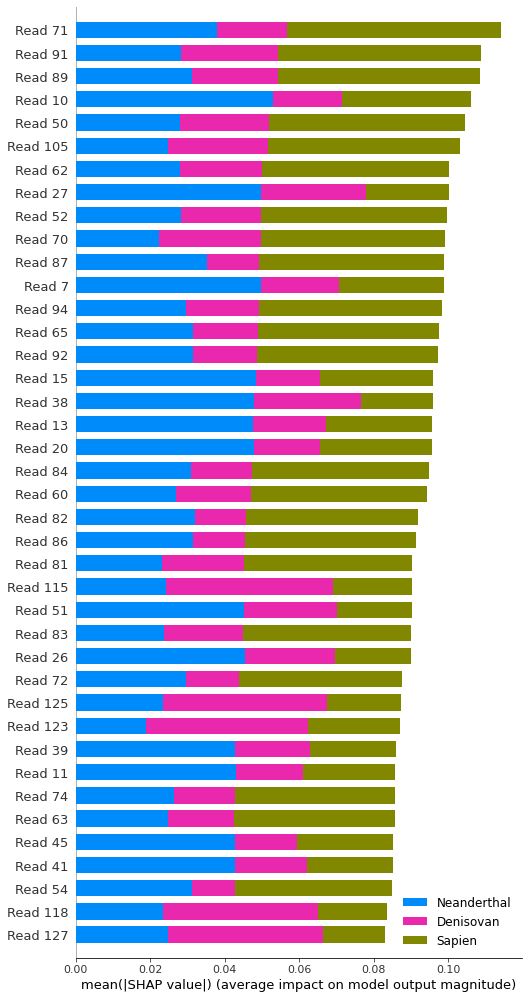

Force plots
Homo Sapiens:


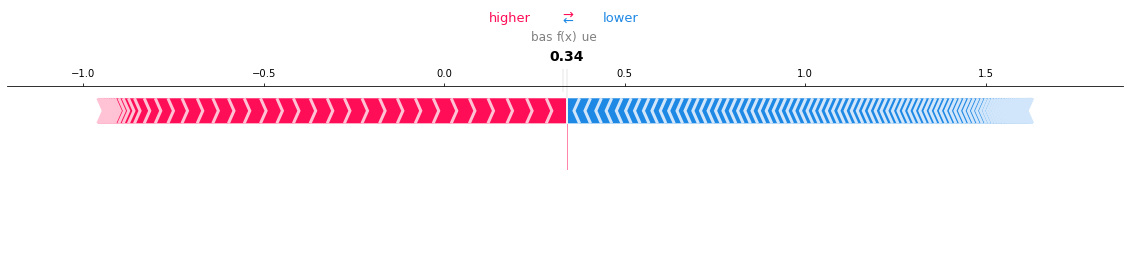

Neanderthals:


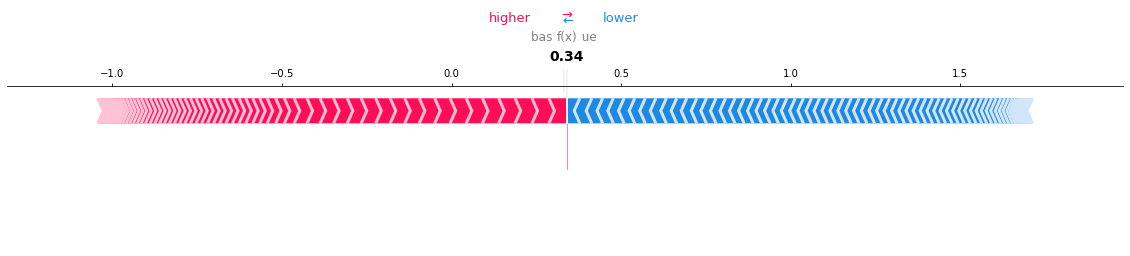

Denisovans:


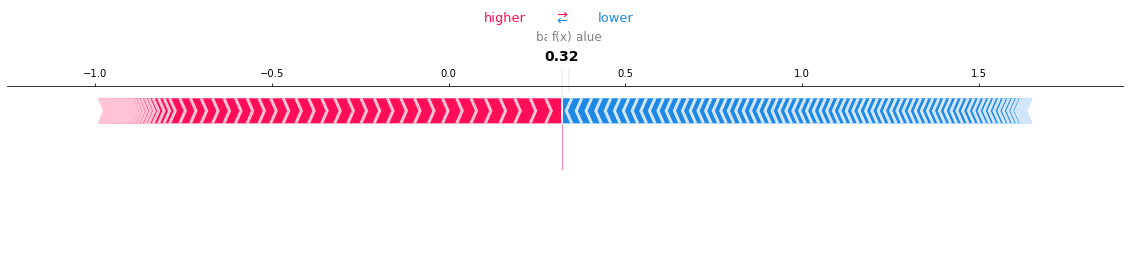

Decision plots:
Homo Sapiens


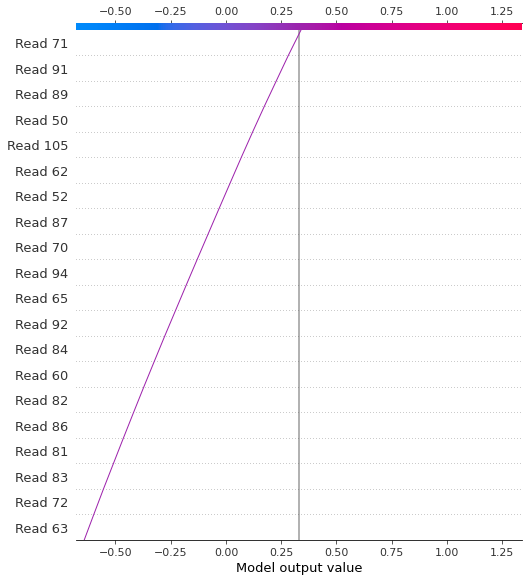

Neanderthals:


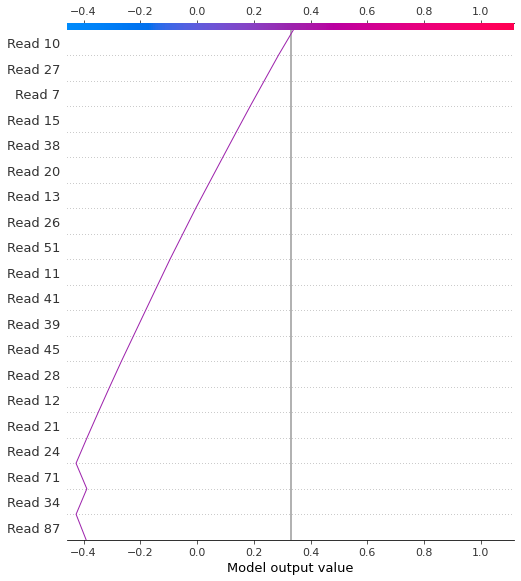

Denisovans:


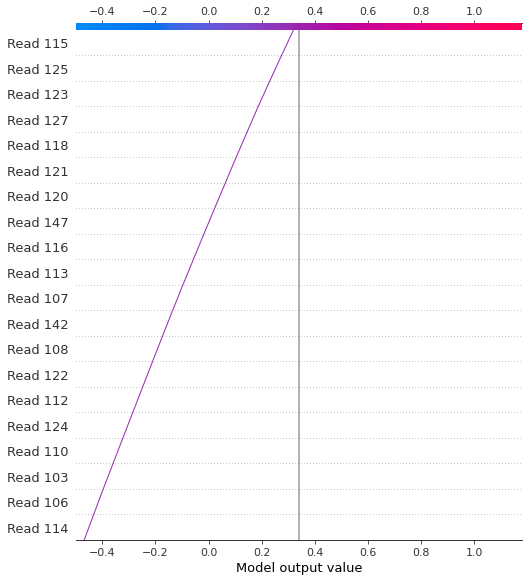

Multi output decision plot:


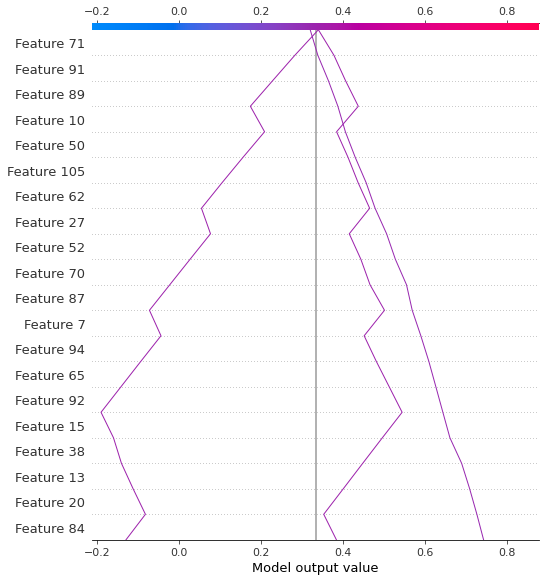

In [26]:
maximum_likelihood_calculator_d_1.plot_shap_values(shaps)

#### Summary plot

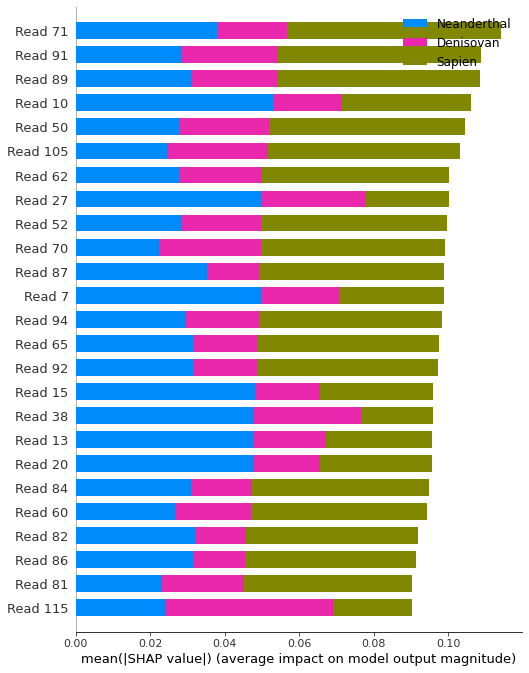

In [27]:
sample = np.ones((1,maximum_likelihood_calculator_d_1.number_of_reads))
shap.initjs()
shap.summary_plot(shap_values=shaps,
                features=sample,
                plot_type="bar",
                class_names = ["Sapien", "Neanderthal", "Denisovan"],
                feature_names = ["Read " + str(i) for i in range(maximum_likelihood_calculator_d_1.number_of_reads)],
                max_display=25,
                )

#### Force plots:

In [29]:
shap.force_plot(maximum_likelihood_calculator_d_1.explainer.expected_value[0], shaps[0], feature_names=["Read " + str(i) for i in range(maximum_likelihood_calculator_d_1.number_of_reads)])


In [30]:
print("Neanderthals")
shap.force_plot(maximum_likelihood_calculator_d_1.explainer.expected_value[1], shaps[1], feature_names=["Read " + str(i) for i in range(maximum_likelihood_calculator_d_1.number_of_reads)])

Neanderthals


In [31]:
print("Denisovans")
shap.force_plot(maximum_likelihood_calculator_d_1.explainer.expected_value[2], shaps[2], feature_names=["Read " + str(i) for i in range(maximum_likelihood_calculator_d_1.number_of_reads)])

Denisovans


#### Decision plots:

Sapienses:


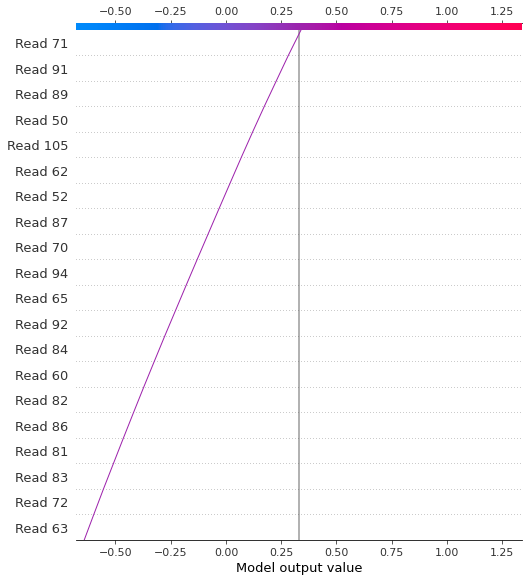

In [32]:
print("Sapienses:")
shap.decision_plot(maximum_likelihood_calculator_d_1.explainer.expected_value[0], shaps[0], feature_names=["Read " + str(i) for i in range(maximum_likelihood_calculator_d_1.number_of_reads)])


Neanderthals:


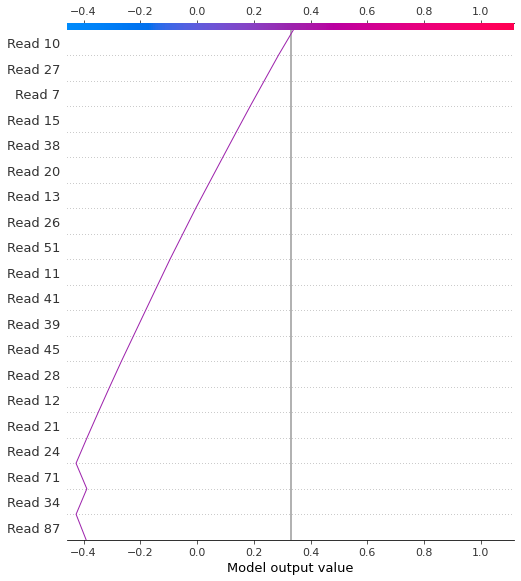

In [33]:
print("Neanderthals:")
shap.decision_plot(maximum_likelihood_calculator_d_1.explainer.expected_value[1], shaps[1], feature_names=["Read " + str(i) for i in range(maximum_likelihood_calculator_d_1.number_of_reads)])

Multi output decision plot:


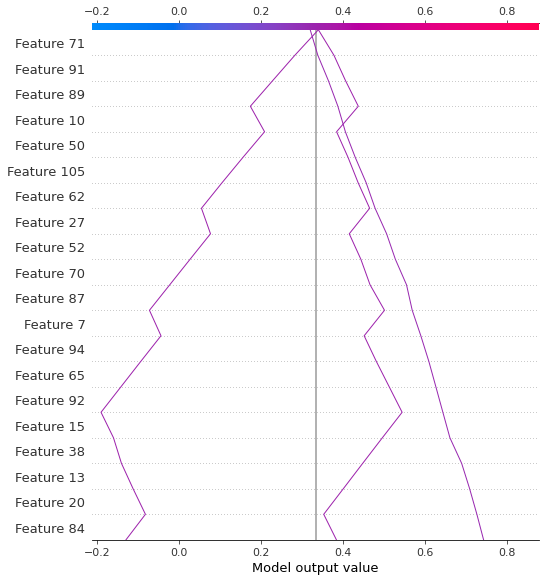

In [35]:
print("Multi output decision plot:")
shap.multioutput_decision_plot(list(maximum_likelihood_calculator_d_1.explainer.expected_value), shaps, row_index=0)

#### Raw values of the shapley estimation, on every species

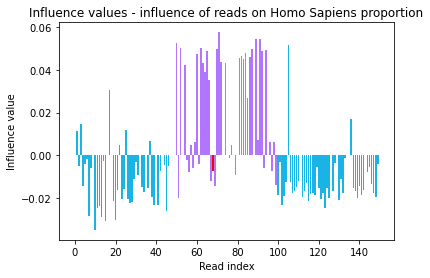

In [36]:
color = [(0.1,0.7,0.9)]*50 + [(0.5,0.1,1,0.6)]*50+[(0.1,0.7,0.9)]*50
color[68] = 'red'
plt.bar([i for i in range(150)],shaps[0][0],color=color)
plt.title("Influence values - influence of reads on Homo Sapiens proportion")
plt.xlabel("Read index")
plt.ylabel("Influence value")
plt.savefig("influence_values_of_homo_sapienses")

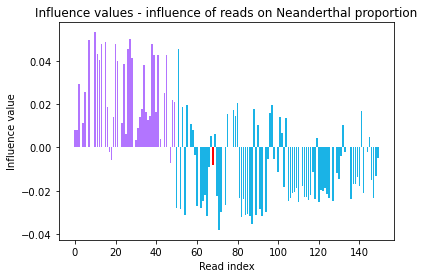

In [37]:
color = [(0.5, 0.1, 1, 0.6)]*50 + [(0.1,0.7,0.9)]*100
color[68] = 'red'
plt.bar([i for i in range(150)],shaps[1][0],  color=color)
plt.title("Influence values - influence of reads on Neanderthal proportion")
plt.xlabel("Read index")
plt.ylabel("Influence value")
plt.savefig("influence_values_of_Neanderthals")

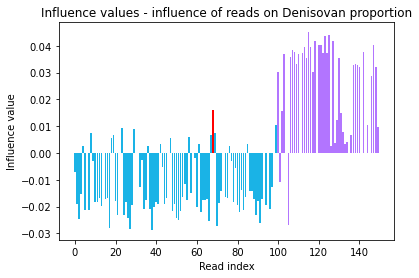

In [38]:
color = [(0.1,0.7,0.9)]*100+[(0.5,0.1,1,0.6)]*50
color[68] = 'red'
plt.bar([i for i in range(150)],shaps[2][0],color=color)
plt.title("Influence values - influence of reads on Denisovan proportion")
plt.xlabel("Read index")
plt.ylabel("Influence value")
plt.savefig("influence_values_of_denisovans")
plt.show()


## As a second exmple, we will load 2 datasets that get similar estimated proportions, and show how their different explanations can be used to differentiate between them

### We will first load the datasets, and show that the algorithm outputs similar result on each of them

In [44]:
all_refs = sapiens_reference_file_names + neanderthals_reference_file_names + denisovan_reference_file_names
all_ref_genomes = []
for i in all_refs:
    genome_as_fasta = list(SeqIO.parse(i, "fasta"))[0]
    genome = str(genome_as_fasta.seq)
    all_ref_genomes.append(genome)
indexes = []
for ind in range(15000):
    first_one = all_ref_genomes[0][ind:ind+50]
    found = True
    for ref in all_ref_genomes:
        cur = ref[max(ind-10, 0):ind+60]
        if (first_one not in cur):
            found = False
            break
    if (found):
        indexes.append(ind)
non_infomatives = []
for i in indexes:
    non_infomatives.append(all_ref_genomes[0][i:i+50])  

In [46]:
d_1 = sapiens_500_generated[:20] + denisovan_500_samples[:20] + non_infomatives[:40]
d_2 = sapiens_500_generated[:40] + denisovan_500_samples[:40]

In [47]:
maximum_likelihood_calculator_on_dataset_1 = ExplainableMaximumLikelihoodCalculator(d_1,
                                                ref_neanderthal_file_names=neanderthals_reference_file_names,
                                                ref_sapien_file_names=sapiens_reference_file_names,
                                                ref_denisovan_file_names=denisovan_reference_file_names,
                                                path_to_substitution_matrix=path_to_frequencies_table,
                                                number_of_jobs=-1)
maximum_likelihood_calculator_on_dataset_2 = ExplainableMaximumLikelihoodCalculator(d_2,
                                                ref_neanderthal_file_names=neanderthals_reference_file_names,
                                                ref_sapien_file_names=sapiens_reference_file_names,
                                                ref_denisovan_file_names=denisovan_reference_file_names,
                                                path_to_substitution_matrix=path_to_frequencies_table,
                                                number_of_jobs=-1)


Loading sequences and calculating alignments to all references, this might take a while. Number of reads:  80
start working on read number 0
start working on read number 10
start working on read number 20
start working on read number 30
start working on read number 40
start working on read number 50
start working on read number 60
start working on read number 70
Loading sequences and calculating alignments to all references, this might take a while. Number of reads:  80
start working on read number 0
start working on read number 10
start working on read number 20
start working on read number 30
start working on read number 40
start working on read number 50
start working on read number 60
start working on read number 70


In [62]:
maximum_likelihood_calculator_on_dataset_1.estimate_species_proportions()

,Homo Sapiens,Neanderthals,Denisovans
Estimation,0.425,0.05,0.525


In [60]:
maximum_likelihood_calculator_on_dataset_2.estimate_species_proportions()

,Homo Sapiens,Neanderthals,Denisovans
Estimation,0.475,0.025,0.5


As you can see, the output on both datasets is very similar. We will now show how using the read level explanaitions, the user can differentiate between them.

### we will now show how the read-level explanations can help differentiate between the datasets

In [63]:
shapleys_d_1 = maximum_likelihood_calculator_on_dataset_1.calculate_shap_values(5000)

1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5000


In [64]:
shapleys_d_2 = maximum_likelihood_calculator_on_dataset_2.calculate_shap_values(5000)

1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5000


Text(0, 0.5, 'Influence value')

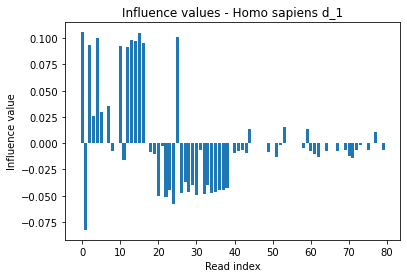

In [72]:
plt.bar([i for i in range(80)],shapleys_d_1[0][0])
plt.title("Influence values - Homo sapiens d_1")
plt.xlabel("Read index")
plt.ylabel("Influence value")


Text(0, 0.5, 'Influence value')

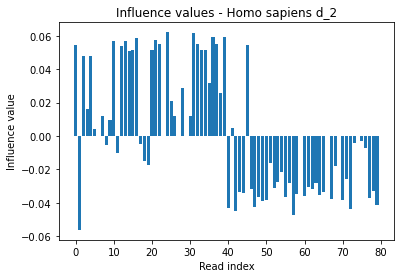

In [73]:
plt.bar([i for i in range(80)],shapleys_d_2[0][0])
plt.title("Influence values - Homo sapiens d_2")
plt.xlabel("Read index")
plt.ylabel("Influence value")


Text(0, 0.5, 'Influence value')

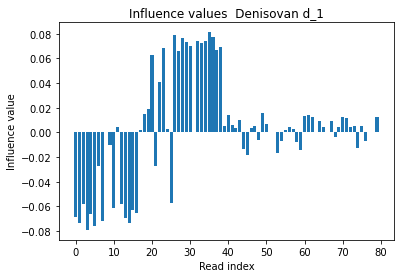

In [74]:
plt.bar([i for i in range(80)],shapleys_d_1[2][0])
plt.title("Influence values  Denisovan d_1")
plt.xlabel("Read index")
plt.ylabel("Influence value")


Text(0, 0.5, 'Influence value')

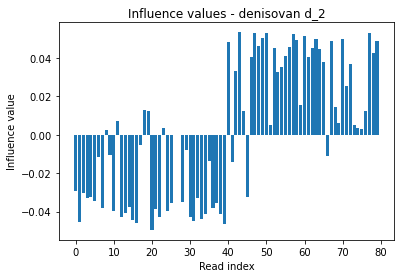

In [75]:
plt.bar([i for i in range(80)],shapleys_d_2[2][0])
plt.title("Influence values - denisovan d_2")
plt.xlabel("Read index")
plt.ylabel("Influence value")


As you can see, despite the same output in the likelihood algorithm, the read level explanations tell a different story, and show that in d_1 only the first half of the reads are important, whereas in d_2, all reads are influential to the output./